In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [3]:
from scripts.data_funcs import *

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# Compile Input Data

In [5]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
input_df = input_df[['region_name', 'date', 'c6_stay_at_home_requirements']]

# Add days since policy change
input_df.loc[:, 'days_since_more_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                                     'c6_stay_at_home_requirements',
                                                                                      type_change='more_strict')
input_df.loc[:, 'days_since_less_strict'] = time_elapsed_since_policy_change(input_df, 
                                                                                     'c6_stay_at_home_requirements',
                                                                                      type_change='less_strict')

# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date'] )

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=30)
input_df['future_cases'] = get_future_cum_cases(input_df, window=30)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge mobility data with input df
input_df = input_df.merge(get_at_away_6_data(), on=['date', 'state'], how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

# Binary encode state names
alpha_ordered_states = input_df.state.unique()
alpha_ordered_states.sort()
binary_state_encoded_df = binary_encode_category(alpha_ordered_states, 'state')
input_df = input_df.merge(binary_state_encoded_df, on='state', how='left')

# Adding day, year, month and dropping date
input_df['day'] = input_df.date.dt.day
input_df['month'] = input_df.date.dt.month
input_df['year'] = input_df.date.dt.year-2020

# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy()
test_df = input_df.loc[(input_df['date'] > date_end)].copy()

# Drop unused cols
train_df = train_df.drop(columns=['state', 'deaths', 'date', 'cases'])
test_df = test_df.drop(columns=['state', 'deaths', 'date', 'cases'])

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# Get input and output for training
x_train_df = train_df.loc[:, train_df.columns != 'future_cases'].copy()
y_train_df = train_df[['future_cases']].copy()

# Get input and output for testing
x_test_df = test_df.loc[:, test_df.columns != 'future_cases'].copy()
y_test_df = test_df[['future_cases']].copy()

# XGBoost Model

In [7]:
# Data DMatrix is special datatype used by XGboost, quicker performance
train_data_dmatrix = xgb.DMatrix(data=x_train_df, label = y_train_df)
test_data_dmatrix = xgb.DMatrix(data=x_test_df, label = y_test_df)

In [19]:
grid = {
        'objective': ['reg:squarederror'],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.3, 0.6, 0.8],
        'learning_rate': [0.05, 0.1, 0.15],
        'alpha': [1, 5, 10]
}
param_grid = ParameterGrid(grid)

In [42]:
# Grid search for optimal parameters
min_params = None
min_cv = None
for params in list(param_grid):
    for num_bst_rnds in [50]:
        # Cross validate for optimal parameters
        cv_results = xgb.cv(dtrain=train_data_dmatrix, params=params, nfold=3,
                            num_boost_round=num_bst_rnds, early_stopping_rounds=10,
                            metrics="rmse", as_pandas=True, seed=123)
        if (not min_cv) or (cv_results["test-rmse-mean"].iloc[-1] < min_cv):
            min_cv = cv_results["test-rmse-mean"].iloc[-1]
            min_params = params.copy()

In [43]:
xg_reg = xgb.train(params=min_params, dtrain=train_data_dmatrix, num_boost_round = 50)

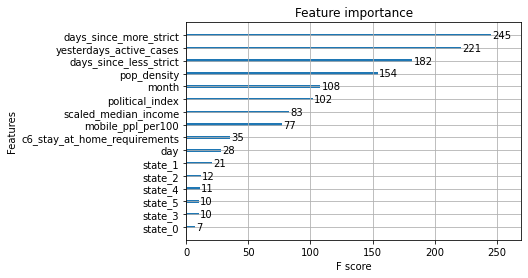

In [44]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [45]:
# Get RMSE on test set
np.sqrt(mean_squared_error(y_test_df, xg_reg.predict(test_data_dmatrix)))

135462.37182833432

In [46]:
min_cv

11899.938801999999